In [1]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics.pairwise import cosine_similarity
import pubchempy as pcp
os.chdir('../')
from util.util import *
os.chdir('notebooks')


import IPython.display as Disp

In [23]:
pl_full = pd.read_pickle('../database/plasticizer_data_v9_top_similar.pkl')
org_full = pd.read_pickle('../data/pubchem/org_desc_fps_v3.pkl')
linolein = pd.read_pickle('../data/pubchem/linolein_test.pkl')
linolein.columns = [str(col) for col in linolein.columns]
linolein = linolein[pl_full.columns[1:]]

In [24]:
pl_og = pd.read_pickle('../database/plasticizer_data_v8_desc_fps.pkl')
og_smiles = pl_og['SMILES'].to_numpy()
top_sim_smiles = pl_full['SMILES'].to_numpy()
og_idxs = []
for i, smile in enumerate(og_smiles):
    if smile in top_sim_smiles:
        pass
    else:
        og_idxs.append(i)
pl_og = pl_og.iloc[og_idxs]

In [25]:
pl_set, org_set = pca_data_split(pl_full, org_full, n=org_full.shape[0])

In [26]:
sf = 0.2
pl_ics, org_ics, pca, scaler = run_pca(pl_set, org_set, scaling_factor=sf)

In [27]:
lin_data = linolein.to_numpy()
lin_data = scaler.transform(lin_data)
lin_data[:,145:] *= sf
lin_ics = pca.transform(lin_data)

og_data = pl_og[pl_og.columns[1:]].to_numpy()
og_data = scaler.transform(og_data)
og_data[:,145:] *= sf
og_ics = pca.transform(og_data)

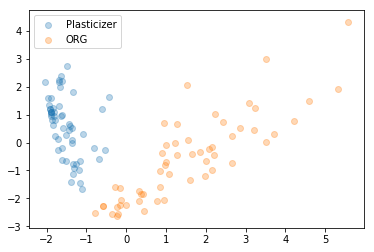

In [28]:
plt.scatter(pl_ics[0][:,0], pl_ics[0][:,1], label='Plasticizer', alpha=0.3)
plt.scatter(org_ics[0][:,0], org_ics[0][:,1], label='ORG', alpha=0.3)
plt.legend(loc='best')
plt.show()

In [29]:
kde, xs, ys = calc_2D_kde(pl_ics[0], [-3.5,6], [-4,5])

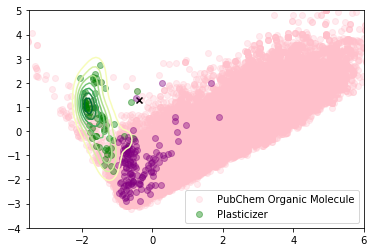

In [31]:
plt.scatter(org_ics[1][:,0], org_ics[1][:,1], label='PubChem Organic Molecule', alpha=0.3, c='pink')
plt.contour(xs, ys, kde, cmap='YlGn')
plt.scatter(pl_ics[0][:,0], pl_ics[0][:,1], label='Plasticizer', alpha=0.4, c='green')
plt.scatter(pl_ics[1][:,0], pl_ics[1][:,1], alpha=0.4, c='green')
plt.scatter(lin_ics[:,0], lin_ics[:,1], c='black', marker='x')
plt.scatter(og_ics[:,0], og_ics[:,1], c='purple', marker='o', alpha=0.4)
plt.xlim([-3.5,6])
plt.ylim([-4,5])
plt.legend(loc='best')
plt.show()

In [13]:
lin_ics

array([[-0.28297679,  0.46904544]])

In [14]:
pl_train_kdes = []
org_test_kdes = []
org_test_smiles = []
lin_kde = get_2D_kde_value(lin_ics[0], kde, xs, ys)
for train_pl in pl_ics[0]:
    pl_train_kdes.append(get_2D_kde_value(train_pl, kde, xs, ys))
for i, test_org in enumerate(org_ics[1]):
    try:
        org_test_kdes.append(get_2D_kde_value(test_org, kde, xs, ys))
        org_test_smiles.append(org_set[3][i])
    except IndexError:
        pass

In [15]:
normalizer = max(pl_train_kdes)
for i, score in enumerate(org_test_kdes):
    org_test_kdes[i] /= normalizer
for i, score in enumerate(pl_train_kdes):
    pl_train_kdes[i] /= normalizer
lin_kde /= normalizer

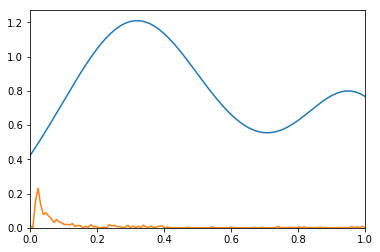

In [16]:
sns.distplot(pl_train_kdes, hist=False, kde=True)
sns.distplot(org_test_kdes, hist=False, kde=True)
plt.xlim([0,1])
plt.show()

In [17]:
org_scores, org_structs = zip(*reversed(sorted(zip(org_test_kdes, org_test_smiles))))

In [18]:
pl_smiles = pd.read_pickle('../database/plasticizer_data_v8_desc_fps.pkl')
pl_smiles = pl_smiles['SMILES'].to_list()

In [19]:
hits = 0
for i, (score, struct) in enumerate(zip(org_scores, org_structs)):
    if struct in pl_smiles:
        pass
    elif '(=O)C1=CC=CC=C1C(=O)' in struct:
        pass
    else:
        print(i, struct, score)
        hits += 1
        if hits > 25:
            break

26 C1=CC=C(C(=C1)C(=O)O)C(=O)OCCCCO 0.5484638220782605
33 C1=CC=C(C(=C1)C(=O)[O-])C(=O)[O-].[K+].[K+] 0.3922443382902022
34 CCCCCCCOC(=O)C1=CC=C(C=C1)O 0.39138003905436075
35 C1=CC=C(C(=C1)C(=O)[O-])C(=O)[O-].[Na+].[Na+] 0.39138003905436075
36 C1=CC=C(C(=C1)C(=O)O)C(=O)[O-].[K+] 0.39138003905436075
38 CC(=O)OC=C.C1=CC=C(C(=C1)C(=O)O)C(=O)O 0.38900339038348947
40 C1=CC=C(C(=C1)C(=O)O)C(=O)[O-].[Na+] 0.3859787681593458
41 C1=CC=C2C(=C1)C(=O)OC2=O 0.382282419019435
43 C1COCC2=CC=CC=C2COCCOCC3=CC=CC=C3CO1 0.37584902717257385
44 C1CCC(CC1)OC(=O)C2=CC=CC=C2C(=O)O 0.3640677093775496
45 C1=CC=C(C(=C1)C(=O)[O-])C(=O)[O-] 0.36224053664713696
46 C1=CC=C(C(=C1)C(=O)O)C(=O)O 0.36224053664713696
49 CC(=O)OCC1=CC=CC=C1C(=O)O 0.3499441573611224
50 C1C(O1)COC(=O)C2=CC=CC=C2C(=O)OCC3CO3 0.3494570878192704
51 CC1=CC=CC=C1C(=O)OCCN(C)C 0.3489959647746608
52 CC1=CC(=C(C=C1)C(=O)O)C 0.34195323546110334
53 CC1=C(C(=CC=C1)C(=O)O)C(=O)O 0.3404038565331027
54 C1=CC=C(C(=C1)C(=O)O)C(=O)OO 0.3404038565331027
55 C

In [20]:
lin_kde

0.012355644677353478

In [ ]:
## Testing Similarity Metric
pl_data = pl_full[pl_full.columns[1:]].to_numpy()
org_data = org_full[org_full.columns[1:]].to_numpy()
org_smiles = org_full['SMILES'].to_numpy()
features = pl_full.columns[1:146].to_list()

sf = 0.2
## Split into test and train
rand_idxs = np.random.choice(np.arange(org_data.shape[0]), size=org_data.shape[0])
train_idxs = rand_idxs[:pl_data.shape[0]]
test_idxs = rand_idxs[pl_data.shape[0]:]
org_train = org_data[train_idxs,:]
org_test = org_data[test_idxs,:]

train_set1 = np.concatenate([pl_data, org_set1], axis=0)

## PCA Model 1
scaler = MinMaxScaler()
train_set1 = scaler.fit_transform(train_set1)
train_set1[:,145:] *= sf
pca1 = PCA(25)
ics_set1 = pca1.fit_transform(train_set1)
pl_ics_set1 = ics_set1[:71,:2]
org_ics_set1 = ics_set1[71:,:2]





In [ ]:
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.show()

In [ ]:
plt.scatter(pl_ics_set1[:,0], pl_ics_set1[:,1], label='Plasticizer', alpha=0.3)
plt.scatter(org_ics_set1[:,0], org_ics_set1[:,1], label='ORG', alpha=0.3)
plt.legend(loc='best')
plt.show()